In [1]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [2]:
%%bash
cd .. && make clean && make

In [3]:
config_name = 'tunnel'
conf = load_conf(config_name)

In [4]:
# Contains tuple of:
# - params
# - data_pot
# - data_psi2[ |Φ|, Re{Φ}, Im{Φ} ]
# - data_obs[t, prob, prob, E, xmoy, x2moy, pmoy, p2moy]
E = 1283.2037962506  # Energy of particle with 0 potential
dataset = run_with_params(
    config_name,
    gen_variations({
        'V0': [E/2, E, E*1.5]
    })
)

Running simulations... Done 3/3


In [5]:
def extract(dataset: tuple[dict, np.ndarray, np.ndarray, np.ndarray]) -> tuple[np.ndarray, ...]:
    params, data_pot, data_psi2, data_obs = dataset
    x = data_pot[:,0]
    t = data_obs[:,0]
    prob_left = data_obs[:,1]
    prob_right = data_obs[:,2]
    H_moy = data_obs[:,3]
    x_moy = data_obs[:,4]
    x2_moy = data_obs[:,5]
    p_moy = data_obs[:,6]
    p2_moy = data_obs[:,7]

    delta_x = np.sqrt(x2_moy - x_moy**2)
    delta_p = np.sqrt(p2_moy - p_moy**2)

    return x, t, prob_left, prob_right, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p

# Plots position, proba

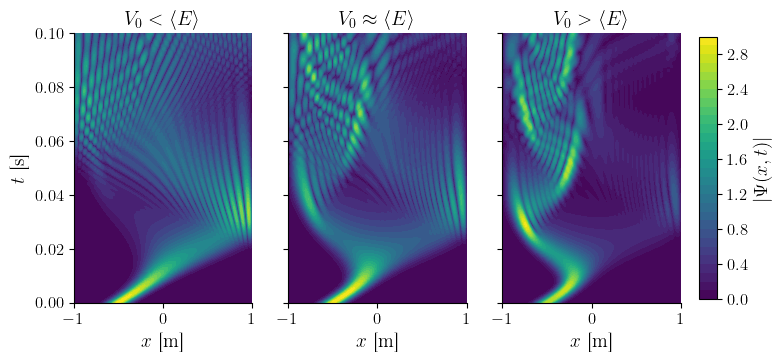

In [6]:
%matplotlib inline

fig, feur = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True)
ax: list[plt.Axes] = feur
magic = [r'<', r'\approx', r'>']
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset):
    x, t, prob_left, prob_right, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p = \
        extract((params, data_pot, data_psi2, data_obs))
    X, Y = np.meshgrid(x, t)
    im = ax[i].contourf(X, Y, np.sqrt(data_psi2[:,::3]), levels=32)
    ax[i].set_xlabel(r'$x$ [m]')
    ax[i].set_title(f'$V_0 {magic[i]} \\langle E \\rangle$')

ax[0].set_ylabel(r'$t$ [s]')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.02, 0.75])
fig.colorbar(im, cax=cbar_ax).set_label(r'$|\Psi(x,t)|$')
plt.savefig(export_path + 'tunnel_normpsi.png')

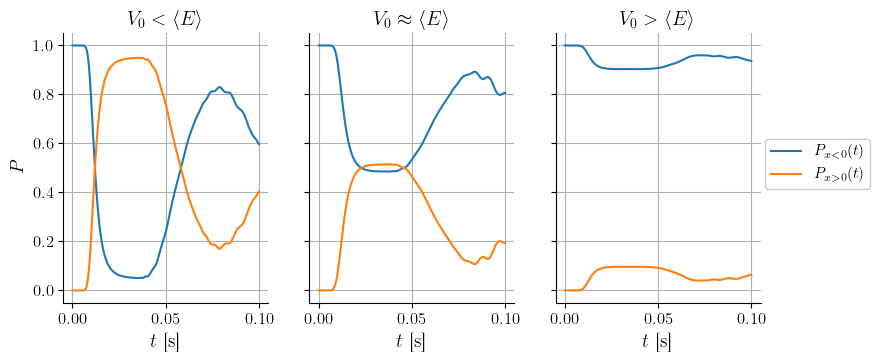

In [7]:
%matplotlib inline

fig, feur = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True)
ax: list[plt.Axes] = feur
magic = [r'<', r'\approx', r'>']
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset):
    x, t, prob_left, prob_right, H_moy, x_moy, x2_moy, p_moy, p2_moy, delta_x, delta_p = \
        extract((params, data_pot, data_psi2, data_obs))
    if i==0:
        label_left = r'$P_{x<0}(t)$'
        label_right = r'$P_{x>0}(t)$'
    else:
        label_left, label_right = None, None
    ax[i].plot(t, prob_left, label=label_left)
    ax[i].plot(t, prob_right, label=label_right)
    ax[i].set_xlabel(r'$t$ [s]')
    ax[i].set_title(f'$V_0 {magic[i]} \\langle E \\rangle$')
    ax[i].grid()

ax[0].set_ylabel(r'$P$')
fig.legend(bbox_to_anchor=(1.03,0.6))
plt.savefig(export_path + 'tunnel_probtrans.pdf')

# Convergence

In [19]:
def extract_at_time(dataset: tuple[dict, np.ndarray, np.ndarray, np.ndarray], time_cut) -> tuple[np.ndarray, ...]:
    params, data_pot, data_psi2, data_obs = dataset
    t = data_obs[:,0]
    index = np.argmin(np.abs(t-time_cut))
    prob_right = data_obs[:,2][index]
    H_moy = data_obs[:,3][index]

    return t[index], prob_right, H_moy

In [39]:
# Nintervals = np.geomspace(256, 8192, 20).astype(int)
Nintervals = (2**np.arange(8, 14, step=0.5)).astype(int)

dataset_conv_nx = run_with_params(
    config_name,
    gen_variations({
        'V0': [E],
        'Nintervals': Nintervals,
        'convergence': ['true']
    })
)

Running simulations... Done 12/12


In [40]:
probs_dx = []
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset_conv_nx):
    t, prob, E = extract_at_time((params, data_pot, data_psi2, data_obs), time_cut=0.03)
    probs_dx.append(prob)
probs_dx = np.array(probs_dx)

valeur convergée: prob_trans = -251.77251870696134*0 + 0.4762376663904359


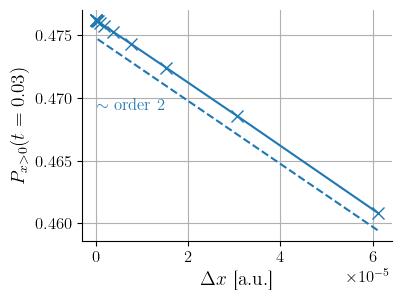

In [41]:
L = conf['xR'] - conf['xL']
dxs = L/Nintervals
plt.plot(dxs[0:]**2, probs_dx[0:], marker='x')

coefs = np.polyfit(dxs**2, probs_dx, 1)
print(f"valeur convergée: prob_trans = {coefs[0]}*0 + {coefs[1]}")
plt.plot(dxs**2, (dxs**2)*coefs[0] + coefs[1]*(1-3*1e-3), '--', color='tab:blue')
plt.annotate(r'$\sim$ order 2', (0, coefs[1]*(1-1.5*1e-2)), xycoords='data', color='tab:blue')

plt.xlabel(r"$\Delta x$ [a.u.]")
plt.ylabel(r"$P_{x>0}(t=0.03)$")
plt.grid()
plt.savefig(export_path + 'conv_dx.pdf')

In [54]:
# delta_ts = np.linspace(1e-5, 1e-6, 64)
factors = np.array([5, 3, 2, 1])
dts = np.concatenate((factors*1e-5, factors*1e-6))

dataset_conv_ts = run_with_params(
    config_name,
    gen_variations({
        'V0': [E],
        'Nintervals': [512],
        'dt': dts,
        'convergence': ['true']
    })
)

Running simulations... Done 8/8


In [55]:
probs_dt1 = []
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset_conv_ts):
    t, prob, E = extract_at_time((params, data_pot, data_psi2, data_obs), time_cut=0.03)
    probs_dt1.append(prob)
    # print(t)
probs_dt1 = np.array(probs_dt1)


valeur convergée: prob_trans = -8604.77872458944*0 + 0.47664884622009907


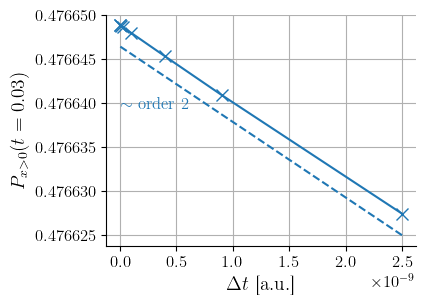

In [56]:
plt.plot(dts**2, probs_dt1, marker='x')

coefs = np.polyfit(dts**2, probs_dt1, 1)
print(f"valeur convergée: prob_trans = {coefs[0]}*0 + {coefs[1]}")
plt.plot(dts**2, (dts**2)*coefs[0] + coefs[1]*(1-5*1e-6), '--', color='tab:blue')
plt.annotate(r'$\sim$ order 2', (0, coefs[1]*(1-2*1e-5)), xycoords='data', color='tab:blue')

plt.xlabel(r"$\Delta t$ [a.u.]")
plt.ylabel(r"$P_{x>0}(t=0.03)$")
plt.grid()
plt.savefig(export_path + 'conv_dt.pdf')

In [45]:
V0s = np.linspace(0.4, 3, 32) * E

dataset_conv_Es = run_with_params(
    config_name,
    gen_variations({
        'V0': V0s,
        'Nintervals': [512],
    })
)

Running simulations... Done 32/32


In [46]:
probs_E = []
E_moys = []
for i, (params, data_pot, data_psi2, data_obs) in enumerate(dataset_conv_Es):
    t, prob, E = extract_at_time((params, data_pot, data_psi2, data_obs), time_cut=0.03)
    # print(t)
    probs_E.append(prob)
    E_moys.append(E)
probs_E = np.array(probs_E)
E_moys = np.array(E_moys)

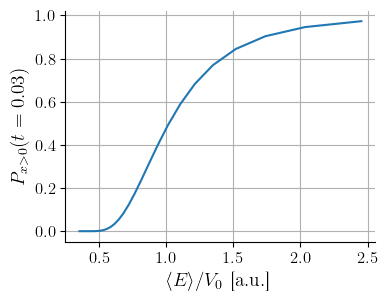

In [47]:
plt.plot(E_moys/V0s, probs_E)

plt.xlabel(r"$\langle E \rangle / V_0$ [a.u.]")
plt.ylabel(r"$P_{x>0}(t=0.03)$")
plt.grid()
plt.savefig(export_path + 'energy_probtrans.pdf')

# Animate

In [8]:
%matplotlib qt
import matplotlib.animation as mpla

plt.figure(figsize=(8, 6))

line1, = plt.plot(data_pot[:,0], data_psi2[0,::3])
line2, = plt.plot(data_pot[:,0], data_psi2[0,1::3])
line3, = plt.plot(data_pot[:,0], data_psi2[0,2::3])
size = data_psi2.shape[0]


def animate(i) -> Any:
    idx = i % size
    line1.set_data(data_pot[:,0], data_psi2[idx,::3])
    line2.set_data(data_pot[:,0], data_psi2[idx,1::3])
    line3.set_data(data_pot[:,0], data_psi2[idx,2::3])

anim = mpla.FuncAnimation(plt.gcf(), animate, interval=20, cache_frame_data=True, frames=size)

plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$|\Psi|^2$')
# plt.ylim(-2, 2)
plt.grid()
plt.tight_layout()